Ομάδα 4

Νίκος Χάιδος, AM: 03118096

Αργύρης Μανέτας, AM:            03117019

Ελευθέριος Λυμπερόπουλος, AM:   03117061

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade somoclu
!pip install -U gensim


In [ ]:
import numpy as np
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
from scipy import sparse
import operator
from nltk.corpus import names
import textwrap
import somoclu
import matplotlib
import gensim.downloader



#from nltk.tag.stanford import NERTagger


In [ ]:
#Κατεβάζουμε το προεκπαιδευμένο μοντέλο google-news-300 καθώς το χρησιμοποιούμε στην προεπεξεργασία και στο κομμάτι της βαθιάς μάθησης
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)


In [ ]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 4

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

Η μεταβλητή df_data_2 έχει γραμμές όσες και οι ομάδες και 5000 στήλες. Στην γραμμή 4, η οποία αντιστοιχεί στην την ομάδα μας έχει τους δείκτες των ταινίες που θα αποτελέσουν το σύνολο δεδομένων μας.

In [ ]:
print(df_data_2)
"""print(df_data_1.iloc[:])
print(df_data_1.iloc[:,[2]].values)"""
print(type(summaries))

         0      1      2      3      4  ...   4995   4996   4997   4998   4999
0    21221  20744  21398  21596  1669   ...  4872   10343  21028  14883  21082
1    2003   7257   6694   13925  2168   ...  2420   4686   7318   13393  5237 
2    20629  18745  9336   4509   4102   ...  7598   18264  16985  16278  21291
3    14532  12504  2180   8667   15406  ...  18546  11566  6594   16039  7470 
4    2810   7810   2453   49     8514   ...  17189  14501  21099  3434   14617
..    ...    ...    ...   ..      ...   ...    ...    ...    ...   ...     ...
134  13219  14990  18111  20649  9525   ...  12316  6065   7042   16578  8443 
135  8384   17183  2605   11081  522    ...  5030   12606  16445  2289   6381 
136  5657   3212   6327   4977   21420  ...  16268  6476   3938   16362  18517
137  21760  21768  21865  11369  18863  ...  21089  2173   20102  8335   11634
138  13102  5874   7256   17402  21746  ...  21317  17709  21325  5558   11801

[139 rows x 5000 columns]
<class 'numpy.ndarray'>


In [ ]:
print(corpus_df)

#Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

##Προεπεξεργασία 

Σε αυτό το μέρος θα υλοποιήσουμε ένα σύστημα συστάσεων ταινιών το οποίο θα βασίζεται στο περιεχόμενο και εν προκειμένω στις συνόψεις των ταινιών. Το σύστημα δηλαδή θα προτείναι ταινίες τις οποίες θεωρεί ότι είναι όμοιες με μια ταινία που θα επιλέξουμε εμείς.

Για την εξόρυξη κειμένου είναι απαραίτητη η προεπεξεργασία του κειμένου ώστε και να φιλτραριστούν λέξεις που δεν προσφέρουν πληροφορίες αλλά και να αντιμετωπιστούν άλλα προβλήματα, όπως ότι τα κεφαλαία με τα μικρά θεωρούνται διαφορετικοί χαρακτήρες και τα λοιπά.

Παρακάτω εκτυπώνουμε διάφορα στοιχεία του πίνακα summaries, ώστε να παρουσιαστούν περιπτώσεις όπου η προεπεξεργασία είναι απαραίτητη

In [ ]:
nltk.download('punkt')
print(textwrap.fill(summaries[-2][0], 150))

words = nltk.word_tokenize(summaries[-2][0])
print(words)

It stars Joe Shishido as a hitman who, along with his sidekick played by Jerry Fujio, is hired by the yakuza to eliminate a rival gang's boss. The two
are captured after the job, escape and are waylaid once again resulting in a climatic battle. The film was among Shishido's first starring roles,
cementing him as a hardboiled action hero, and remains a personal favourite of the 170 films he made at Nikkatsu.<ref name  Schilling | first  No
Borders, No Limits: Nikkatsu Action Cinema | publisher  2007 | isbn  http://www.fabpress.com/vsearch.php?CO 79, 96 }}
['It', 'stars', 'Joe', 'Shishido', 'as', 'a', 'hitman', 'who', ',', 'along', 'with', 'his', 'sidekick', 'played', 'by', 'Jerry', 'Fujio', ',', 'is', 'hired', 'by', 'the', 'yakuza', 'to', 'eliminate', 'a', 'rival', 'gang', "'s", 'boss', '.', 'The', 'two', 'are', 'captured', 'after', 'the', 'job', ',', 'escape', 'and', 'are', 'waylaid', 'once', 'again', 'resulting', 'in', 'a', 'climatic', 'battle', '.', 'The', 'film', 'was', 'among', 'Sh

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Στην παραπάνω σύνοψη παρατηρούμε τα εξής:
1. Υπάρχουν πολλές λέξεις που δεν προσφέρουν ουσιαστική πληροφορία για το περιεχόμενο της συγκεκριμένης ταινίας και απλά αυξάνουν το μέγεθος του dataset μας. Τέτοιες λέξεις είναι το It, a, by και τα λοίπα. Αυτά είναι τα λεγόμενα stopwords τα οποία στη συνέχεια θα αφαιρέσουμε. 
2. Υπάρχουν σημεία στίξης, όπως κόμματα που δεν προσφέρουν πληροφορία
3. Στην περίπτωση της λέξης gang's όπου το 's δηλώνει κτήση, δημιουργούνται δύο λέξεις, όπου η μία είναι το 's που δεν προσφέρει πληροφορία.
3. Υπάρχουν αριθμοί που επίσης πρέπει να εξαλειφθούν.
4. Υπάρχουν άλλα σύμβολα όπως |, :, < 
5. Υπάρχει url από το οποίο δημιουργούνται τα εξής tokens: 'http', ':', '//www.fabpress.com/vsearch.php'

In [ ]:
print(textwrap.fill(summaries[4278][0], 150))
words = nltk.word_tokenize(summaries[4278][0])
print(words)

Despite having written several books describing marriage as an "old-fashioned superstition", Mortimer Brewster  falls in love with Elaine Harper , who
grew up next door to him in Brooklyn, and, on Halloween day, they marry. Immediately after the wedding, Mortimer visits the eccentric but lovable
relatives who raised him and who still live in his old family home: his elderly aunts Abby  and Martha , and his brother Teddy ([[John Alexander , who
believes he is Theodore Roosevelt. Each time Teddy goes upstairs, he yells "Charge!" and takes the stairs at a run, imitating Roosevelt's famous
charge up San Juan Hill. Mortimer finds a corpse hidden in a window seat and assumes that Teddy has committed murder under some delusion, but his
aunts explain that they are responsible . They explain in the most innocent terms that they have developed what Mortimer calls the "very bad habit" of
ending the presumed suffering of lonely old bachelors by serving them elderberry wine spiked with arsenic, str

Σε αυτό το παράδειγμα παρατηρούμε την ύπαρξη του token: "", όπου μια απλή υλοποίηση για το φιλτράρισμα αυτών των συμβόλων μπορεί να μην τα διαγράψει. Για αυτό το λόγο θα λάβουμε υπόψη την περίπτωση όπου τέτοιοι χαρακτήρες είναι συνενωμένοι

In [ ]:
print(textwrap.fill(summaries[1252][0], 150))
words = nltk.word_tokenize(summaries[1252][0])
print(words)

The story is set in 1984. Elmeri Hautamäki  is a man who has lived his entire life in a mental institution. He escapes with his homosexual nurse
Janne-Petteri Broman  and is joined by the Kagelberg-twins Jönssi and Dille  on a quest for the hidden gold treasure of his father Kyrpä-Jooseppi
Hautamäki, who was killed by a fleeing German soldier Peter North  back in 1944, in Lapland. Their escape leads them to be pursued by not only the
Mental Institute's doctors Rasikangas and Kulokoski  but by the police as well. The motley crew arrives at Elmeri's father's site but are unable to
extract a reasonable amount of gold from the river. At the dead of night Jönssi stumbles on a buried German motorbike and the bodies of two dead SS-
troopers. They find out that the motorbike's side-cart carries a chest full of Third Reich gold. Later a police-pursuit lands the group on the grounds
of gay baron Eugen von Lahtinen  during a poetry-themed spring-celebration. The gold-exchanger that the group goes

Σε αυτή την περίπτωση υπάρχουν λέξεις με χαρακτήρες που δεν υπάρχουν στα αγγλικά όπως το ö στη λέξη Jönssi.

Στην συνέχεια λοιπόν φιλτράρουμε τα stopwords και σημεία στίξης, καθώς και τα ονόματα καθώς δεν προσφέρουν κάποια πληροφορία.

In [ ]:
nltk.download('stopwords')
print("Τα stopwords: ", stopwords.words('english'))
print("Τα σημεία στίξης:", string.punctuation)

Τα stopwords:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Συνάρτηση η οποία φιλτράρει το punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

#Συνάρτηση που φιλτράρει ονόματα
nltk.download('names')
names_list = names.words('male.txt') + names.words('female.txt')


def remove_names(text):
  text = text.split()
  namesfreelist = [i for i in text if i not in names_list]
  namesfree = " ".join(namesfreelist)
  return namesfree

#Αποθηκεύουμε το κείμενο χωρίς τα punctuations
corpus_df['clean_msg']= corpus_df[0].apply(lambda x:remove_punctuation(x))

#Aφαιρούμε και τα ονόματα
corpus_df['no_names']= corpus_df['clean_msg'].apply(lambda x:remove_names(x))

#Απαραίτητο για να φαίνεται όλο τοκείμενο
pd.set_option('display.max_colwidth', -1)
corpus_df = corpus_df [[0,'clean_msg','no_names']]
corpus_df.head()

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Παρατηρούμε, λοιπόν ότι έχουν διαγραφεί όλα τα punctuations. Έπειτα μετατρέπουμε τα κεφαλαία σε πεζά.

In [ ]:
corpus_df['lowered']= corpus_df['no_names'].apply(lambda x: x.lower())
corpus_df[['no_names', 'lowered']].head()

no_names                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Για την διαγραφή των URLS ορίζουμε την παρακάτω συνάρτηση και την δοκιμάζουμε στην περίληψη όπου είχαμε βρει URL και παρατηρούμε ότι αυτό διαγράφεται. Ύστερα την εφαρμόζουμε σε όλο το dataset

In [ ]:
def remove_urls(text):
  ans = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", text)
  return ans
print(textwrap.fill(summaries[-2][0], 150))
print("------------------------------------------------------------------------------------------------------------------------------------------------------")
print(textwrap.fill(remove_urls(summaries[-2][0]), 150))  

It stars Joe Shishido as a hitman who, along with his sidekick played by Jerry Fujio, is hired by the yakuza to eliminate a rival gang's boss. The two
are captured after the job, escape and are waylaid once again resulting in a climatic battle. The film was among Shishido's first starring roles,
cementing him as a hardboiled action hero, and remains a personal favourite of the 170 films he made at Nikkatsu.<ref name  Schilling | first  No
Borders, No Limits: Nikkatsu Action Cinema | publisher  2007 | isbn  http://www.fabpress.com/vsearch.php?CO 79, 96 }}
------------------------------------------------------------------------------------------------------------------------------------------------------
It stars Joe Shishido as a hitman who, along with his sidekick played by Jerry Fujio, is hired by the yakuza to eliminate a rival gang's boss. The two
are captured after the job, escape and are waylaid once again resulting in a climatic battle. The film was among Shishido's first starrin

In [ ]:
corpus_df['no_urls'] = corpus_df['lowered'].apply(lambda x: remove_urls(x))

Ύστερα κάνουμε το tokenization

In [ ]:
corpus_df['tokenized'] = corpus_df['no_urls'].apply(lambda x: nltk.word_tokenize(x))
corpus_df.iloc[:5, [-2, -1]]

no_urls                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        tokenized
0  tracking two lost lumberjacks through the night a rescue team nearly follows a hound over a cliff two men rappel down to retrieve the fallen hound but they are killed the third hearing screams down below rappels down to investigate where he finds his team mates dead killed by a unknown thing the third is then killed by a unseen force dr is fed up with dealing with the squalor of city tenements he does not feel he is making a difference he accepts a job from the environmental protection agency to write a report on a logging operation near the androscoggin river in maine the loggers are in a dispute with the local american indian opies the original people dr vernes wife accompanies him on the trip she is pregnant but is apprehensive to tell her husband as he is set against having children when they fly in they meet a man and his two children and who are embarking on a trek into the wilderness they also meet bethel isely the director of the paper mill who is to be their host he tells them about his missing rescue team and lays the blame at the feet of the opies the latter have their own explanation katahdin a vengeful spirit of the forest that has been awakened by the activities of the loggers isely describes katahdin as larger than a dragon with the eyes of a cat as isely drives the couple to their cabin their path is barred by a party of opies they refuse to let iselys people pass and a fight ensues between the leader of the opies hawks and kelso one of iselys heavies the heavy is armed with a chainsaw while hawks has only a broadaxe the scuffle ends with hawks laid on the ground with the chainsaw at his throat the opies relent and let the cars pass and are visibly shocked by the incident while fishing sees a huge salmon devour a duck later after he and have eaten his catch they are attacked in their cabin by a deranged raccoon kills it and sends a tissue sample to be tested the next day hawks and his wife approach dr to put over their side of the story if is concerned about the environment then he should include the people in his assessment something is making the people ill still births mental illness and birth defects are rife hawks takes and to the home of mrai ramonas grandfather claims to have seen katahdin and describes him as part of everything in gods creation sees plant roots growing on the surface that should be underground hawk nets a bullfrogsized tadpole from the water to show has cigarette burns on his hand but feels no pain as the evidence mounts the idyllic setting gradually takes on a sinister hue and tour the paper mill to look for incriminating evidence but the chemicals used in the processing are demonstrated to never leave the plant isely tells them that the water is routinely tested for purity as they leave however notices mercury deposits on maggies boots it is a mutagen that causes birth defects and progressive nerve damage it has long been used in logging as a fungicide because it is cheap it will not show up in iselys water purity tests because it sinks to the bottom needs more evidence and determines to take blood tests from the opies that night the family who have set up a camp in the woods are suddenly assaulted by a ferocious monster the horrified tries to flee but the beast spanks him into a rock killing him the next day as and are taking bl

Και αφαιρούμε τα stopwords.

In [ ]:
#Συνάρτηση που αφαιρεί τα stopwords

list_voc = stopwords.words('english')

def stopwords_names_removal(words, list_voc):
  ans = [i for i in words if i not in list_voc]
  return ans

corpus_df['no_stopwords'] = corpus_df['tokenized'].apply(lambda x:stopwords_names_removal(x, list_voc))  
corpus_df.iloc[:5, [-1]]


,no_stopwords
0,"[tracking, two, lost, lumberjacks, night, rescue, team, nearly, follows, hound, cliff, two, men, rappel, retrieve, fallen, hound, killed, third, hearing, screams, rappels, investigate, finds, team, mates, dead, killed, unknown, thing, third, killed, unseen, force, dr, fed, dealing, squalor, city, tenements, feel, making, difference, accepts, job, environmental, protection, agency, write, report, logging, operation, near, androscoggin, river, maine, loggers, dispute, local, american, indian, opies, original, people, dr, vernes, wife, accompanies, trip, pregnant, apprehensive, tell, husband, set, children, fly, meet, man, two, children, embarking, trek, wilderness, also, meet, bethel, isely, director, paper, mill, host, tells, missing, rescue, team, lays, blame, feet, opies, latter, ...]"
1,"[pandian, arun, police, officers, pallavi, drug, addict, could, stop, habit, eventhough, brother, arun, pleads, one, day, arun, locks, dies, could, nt, use, habitual, drugs, devastated, arun, decides, take, revenge, mohandas, kingpin, drug, mafia, gets, killed, mohandas, airport, restroom, sudhas, young, brother, happens, watch, murder, terrified, make, public, pandian, incharge, case, zeroes, sudha, brother, witness, refuses, madhuri, pleads, help, decides, help, pandian, pandian, gets, abducted, mohandass, men, forcefully, make, drug, addict, climax, reveals, whether, pandian, nab, drug, lord, complete, revenge, friend, arun]"
2,"[dey, plays, 17yearold, lured, participating, robbery, captured, authorities, sent, reformatory, finds, trouble, trying, adjust, sentence, multiplied, appears, may, never, leave, state, custody, becomes, target, unwanted, sexual, advances, inmates, young, africanamerican, lesbian, named, takes, protection, ultimately, sacrifices, life, save, valeries]"
3,"[dr, lowells, research, carried, canyon, country, southern, utah, must, conducted, time, halleys, comet, passing, earth, corporation, trying, find, remote, place, illegally, dump, nuclear, waste, throws, land, destroys, laboratory, spends, rest, film, committing, ecotage, company, trying, recover, land]"
4,"[thanks, genius, conman, conducts, various, schemes, two, friends, halfbreed, steam, engine, girlfriend, loves, men, turn, vie, affection, formulates, extremely, elaborate, plan, steal, 300000, cabot, indianhating, cavalry, man, save, indian, land, trying, steal, every, time, plan, seems, failing, another, trick, sleeve, movie, climaxes, stagecoach, chase, gigantic, explosion]"


Τέλος φιλτράρουμε τις λέξεις που περιέχουν πολλά σημεία στίξης καθώς και τις λέξεις που έχουν μήκος ένα ή δύο. Εκτός από υλοποιούμε και μια πολύ violent τακτική προεπεξεργασίας κατα την οποία φιλτράρονται όλες οι λέξεις που δεν ανήκουν στο pretrain word2vec μοντέλο Google-News καθώς παρατηρήθηκε ότι οι περισσότερες λέξεις του corpus που δεν ανήκουν σε αυτό είναι λέξεις με μικρή αξία, καθώς είτε προκύπτουν από ορθογραφικά λάθη, μη-αγγλικά ονόματα ανθρώπων και άλλα.

In [ ]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)  #bazei false an to gramma den einai sto punctuatio
        if not all(pun):  # all epistrefei false an exei mesa kapoio false
            filtered_words.append(word)
    return filtered_words

def remove_numbers(text):
  ans = [x for x in text if not any(c.isdigit() for c in x)]
  return ans

def remove_short(text):
  ans = [x for x in text if len(x) > 2]
  return ans


def remove_not_in_pretrained(words, model):
  ans = []
  for word in words:
    try:
      model[str(word)]
      ans.append(word)
    except:
      continue  
  return ans    


corpus_df['filtered'] = corpus_df['no_stopwords'].apply(lambda x: thorough_filter(x))
corpus_df['no_short_words'] = corpus_df['filtered'].apply(lambda x: remove_short(x))
corpus_df['final'] = corpus_df['no_short_words'].apply(lambda x: remove_numbers(x))


corpus_df['violent_preprocess'] = corpus_df['final'].apply(lambda x: remove_not_in_pretrained(x, model))
print('Όλα τα διαφορετικά στάδια προεπεξεργασίας φαίνονται παρακάτω')
pd.set_option('display.max_colwidth', -1)
corpus_df.iloc[:5]

Όλα τα διαφορετικά στάδια προεπεξεργασίας φαίνονται παρακάτω


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


0  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               violent_preprocess
0  Tracking two lost lumberjacks through the night, a rescue team nearly follows a hound over a cliff. Two men rappel down to retrieve the fallen hound, but they are killed. The third, hearing screams down below, rappels down to investigate, where he finds his team mates dead, killed by a unknown thing. The third is then, killed by a unseen force Dr. Robert Verne  is fed up with dealing with the squalor of city tenements. He does not feel he is making a difference. He accepts a job from the Environmental Protection Agency to write a report on a logging operation near the Androscoggin River in Maine. The loggers are in a dispute with the local American Indian "Opies" , the original people. Dr. Verne's wife Maggie  accompanies him on the trip. She is pregnant but is apprehensive to tell her husband as he is set against having children. When they fly in, they meet a man, Travis Nelson  and his two children Paul and Kathleen who are embarking on a trek into the wilderness. They also meet Bethel Isely , the director of the paper mill, who is to be their host. He tells them about his missing rescue team and lays the blame at the feet of the Opies. The latter have their own explanation: Katahdin, a vengeful spirit of the forest that has been awakened by the activities of the loggers. Isely describes Katahdin as "larger than a dragon with the eyes of a cat". As Isely drives the couple to their cabin, their path is barred by a party of Opies. They refuse to let Isely's people pass and a fight ensues between the leader of the Opies John Hawks  and Kelso , one of Isely's heavies. The heavy is armed with a chainsaw while Hawks has only a broadaxe. The scuffle ends with Hawks laid on the ground with the chainsaw at his throat. The Opies relent and let the cars pass. Verne and Maggie are visibly shocked by the incident. While fishing, Verne sees a huge salmon devour a duck. Later, after he and Maggie have eaten his catch, they are attacked in their cabin by a deranged raccoon. Verne kills it and sends a tissue sample to be tested. The next day Hawks and his wife Ramona  approach Dr. Verne to put over their side of the story. If Verne is concerned about the environment then he should include the people in his assessment. Something is making the people ill: still births, mental illness and birth defects are rife. Hawks takes Verne and Maggie to the home of Hector M'Rai , Ramona's grandfather. Hector claims to have seen Katahdin and describes him as "part of everything in God's creation". Verne sees plant roots growing on the surface that should be underground; Hawk nets a bullfrog-sized tadpole from the water to show Verne; Hector has cigarette burns on his hand but feels no pain. As the evidence mounts the idyllic setting gradually takes on a sinister hue. Verne and Maggie tour the paper mill to look for incriminating evidence but the chemicals used in the processing are demonstrated to never leave the plant. Isely tells them that the water is routinely tested for purity. As they leave, however, Verne notices mercury deposits on Maggie's boots. It is a mutagen that causes birth defects and progressive nerve damage. It has long been u

In [ ]:
import joblib
from google.colab import files

joblib.dump(corpus_df, "corpus_df.pkl")
files.download('corpus_df.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Μετατροπή σε TFIDF

Σε αυτό το βήμα θα μετατρέψουμε το corpus σε αναπαράσταση tf-idf. Με αυτή την τεχνική κάθε summary αναπαρίσταται από ένα διάνυσμα, το οποίο περιέχει βάρη για τις λέξεις του ολικού corpus. Τα βάρη προσαρμόζονται ανάλογα με την συχνότητα της λέξης στην εκάστοτε σύνοψη καθώς και με το πόσο συχνά εμφανίζονται σε συνόψεις. Μια λέξη η οποία εμφανίζεται σε πάρα πολλά summaries όπως είναι αναμενόμενο δεν θα προσφέρει πολύ πληροφορία επομένως το βάρος της μειώνεται. Επίσης όσο σπανιότερη είναι σε ένα συγκεκριμένο summary, τόσο μικρότερο βάρος πρέπει να έχει.

In [ ]:
def make_final_corpus(text):
  ans = " ".join(text)
  return ans


corpus_df['corpus_preprocessed'] = corpus_df['final'].apply(lambda x: make_final_corpus(x))
corpus_df.head()

corpus_df['violent_final'] = corpus_df['violent_preprocess'].apply(lambda x: make_final_corpus(x))

Ύστερα δοκιμάζουμε διάφορες παραμέτρους για την TfidfVectorizer για το προεπεξεργάσμένο corpus καθώς και για την περίπτωση όπου έχουν φιλτραριστεί οι λέξεις που δεν υπάρχουν στο προεκπαιδευμένο μοντέλο google-news.

Είναι σημαντικό να μειώσουμε την διάσταση των αναπαραστάσεων.

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
corpus_tf_idf_plain = vectorizer.transform(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
print("Το shape της αναπαράστασης tf-idf που προκύπτει για τις default παραμέτρους είναι: ", corpus_tf_idf_plain.shape)

Το shape της αναπαράστασης tf-idf που προκύπτει για τις default παραμέτρους είναι:  (5000, 52525)


Προφανώς μέγεθος διάστασης 52525 είναι πολύ μεγάλο και αυξάνει δραματικά την υπολογιστική πολυπλοκότητα στα επόμενα βήματα, χωρίς να πραγματοποιεί καλύτερες προτάσεις. 

Για να πετύχουμε αυτή την μείωση, πειραματιζόμαστε με τις παραμέτρους min_df, max_df και max_features.
1. Με την παράμετρο min_df αγνοούνται όροι οι οποίοι έχουν document frequency μικρότερο από το ποσοστό που δίνεται. Παρατηρήθηκε ότι μικρές αλλαγές σε αυτή την παράμετρο είχε σημαντικές επιπτώσεις στο πόσοι όροι λαμβάνονται υπόψη.
2. Με την παράμετρο max_df αγνοούνται όροι οι οποίοι έχουν document frequency μεγαλύτερο από το ποσοστό που δίνεται.
3. Η παράμετρος max_features επιβάλλει το να ληφθούν υπόψη μόνο τα ανώτερα max_features ταξινομημένα με την συχνότητα του όρου σε όλο το corpus. 

Προσπαθήσαμε με διάφορους συνδυασμούς να πετύχουμε μέγεθος tf-idf features ανάμεσα σε 3000-5000. Ο έλεγχος των αποτελεσμάτων τους γινόταν μέσω του πλήθους των καλών προτάσεων που γινόντουσαν για την κάθε αναπαράσταση για ταινίες οι οποίες είχαν ήδη σχετικά καλές προτάσεις ακόμα και για τις default τιμές της TfidfVectorizer.
(Για παράδειγμα ταινίες με id: 101, 3984, 10)<br>
Παρατηρήθηκε ότι ένας καλός συνδυασμός παραμέτρων 1, 2 πετύχαινε ίδια ή καλύτερα αποτελέσματα από τη χρήση της παραμέτρου 3.

In [ ]:
vectorizer = TfidfVectorizer(min_df = 0.005, max_df = 0.6)
vectorizer.fit(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
corpus_tf_idf_plain = vectorizer.transform(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
print(corpus_tf_idf_plain.shape)


(5000, 3983)


In [ ]:
vectorizer2 = TfidfVectorizer(min_df = 0.005, max_df = 0.6)
vectorizer2.fit(np.reshape(corpus_df.iloc[:, [-1]].values, 5000).tolist())
corpus_tf_idf_plain_violent = vectorizer2.transform(np.reshape(corpus_df.iloc[:, [-1]].values, 5000).tolist())
print(corpus_tf_idf_plain_violent.shape)

(5000, 3961)


In [ ]:
def cosine_similarity2(vector1, vector2):
  ans = 1 - spatial.distance.cosine(vector1, vector2)
  return ans 


def content_recommender(target_movie, max_recommendations, corpus_type):
  similarities = []
  for movie in corpus_type:
    sim = cosine_similarity2(sparse.csr_matrix.toarray(corpus_type[target_movie]), sparse.csr_matrix.toarray(movie))
    similarities.append(sim)
  similarities_tuple = enumerate(similarities)
  sorted_pairs = sorted(similarities_tuple, key = operator.itemgetter(1), reverse = True)  
  sorted_indices = []
  for index, _ in sorted_pairs:
    sorted_indices.append(index)

  print("Target movie's id: {}\nTitle {}\nSummary: {}\nCategories {}".format(target_movie, titles[target_movie], textwrap.fill(summaries[target_movie][0], 140), categories[target_movie]))
  sorted_indices.remove(target_movie)
  print("\n")
  print("Best Recommendations")
  print("\n")
  for i in range(max_recommendations):
    print("\t{}th most similar movie:\n\t\tid: {}\n\t\tCosine Similarity {} \n\t\tTitle: {}\n\t\tCategories: {}\n\t\tSummary: {}".format(i+1, sorted_indices[i], similarities[sorted_indices[i]], titles[sorted_indices[i]], categories[sorted_indices[i]], textwrap.fill(summaries[sorted_indices[i]][0], 140)))

content_recommender(101, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 101
Title ['Jill Rips']
Summary: Matt Sorenson , a former boxer and San Francisco cop, now makes a living collecting debts for small businesses. The brutal death of his
high-powered younger brother, Michael, changes all that forever. Intent on finding his brother's killer, Sorenson infiltrates the powerful
inner world of politics, business intrigue and casual sex. Rejecting the police and media theory that the murder is the work of a female
prostitute, Sorensen's focus falls on the corrupt big city businessman, Jim Conway. His obsession to discover the killer's identity mounts
as a series of other men are found murdered in a similar fashion. Sorenson loses all objectivity and becomes a vigilante.
Categories ['"Thriller",  "Crime Thriller",  "Erotic thriller"']


Best Recommendations


	1th most similar movie:
		id: 1515
		Cosine Similarity 0.18770256518137085 
		Title: ['Dying God']
		Categories: ['"Horror"']
		Summary: In a dark and decadent city, Sean Fallon - a co

In [ ]:
content_recommender(10, 5, corpus_tf_idf_plain_violent)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 10
Title ['Night of the Juggler']
Summary: A former cop, played by James Brolin, aligns with a street smart young clerk from the New York City dog pound  on a harrowing search for his
daughter who is kidnapped by a psychopath  after being mistaken for a wealthy man's daughter. His search is met with obstacles as he runs
afoul of the police in his pursuit, including a former corrupt colleague bent on revenge against him. Meanwhile, the kidnapper is just as
prepared to kill anybody, including his young hostage, unless his colossal ransom demands are met.
Categories ['"Crime Fiction",  "Action",  "Drama"']


Best Recommendations


	1th most similar movie:
		id: 1960
		Cosine Similarity 0.1928683349141812 
		Title: ['Broken City']
		Categories: ['"Crime Fiction",  "Thriller",  "Drama"']
		Summary: Former cop Billy Taggart begins following the wife of the New York City mayor, Emily Barlow and uncovers a much bigger scandal.
	2th most similar movie:
		id: 2259
		Cosine Sim

Παρατηρούμε ότι και στις δύο παραπάνω περιπτώσεις οι προτάσεις είναι αρκετά καλές, σύμφωνα με τις συνόψεις τους. Πετυχαίνει σε όλες όλα τα genre εκτός από ένα, στο οποίο αν διαβάσουμε το summary του φαίνεται σαν να έχει ομοιότητα με το target movie που επιλέξαμε.

###Cherry Picking:

Θα χρησιμοποιήσουμε την περίπτωση της λιγότερο violent προεπεξεργασίας

Ακολουθούν παραδείγματα που ο recommender επιστρέφει καλά αποτελέσματα

In [ ]:
content_recommender(91, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 91
Title ['Solo']
Summary: Gautham is an orphan who always wishes to get married to a girl from a joint family to experience the love of relationships and elders. He
falls in love with Vaishnavi who belongs to a joint family. He tries to woo her and finally she agrees and fall in love with him too.
Vaishnavi shares a very good relationship with everyone at home especially her dad Naidu . One day he gets to know about his daughter and
Gautham's relationship. He dislikes it as he always wanted to get his daughter married to a guy who belongs to a good family. He sets an
alliance with someone else. What happens next forms the rest.http://www.kothimeer.com/reviewsinner/1/36
Categories ['"Drama"']


Best Recommendations


	1th most similar movie:
		id: 1090
		Cosine Similarity 0.2283394591524721 
		Title: ['Murappennu']
		Categories: ['"Romance Film",  "Drama"']
		Summary: The film revolves around a joint family headed by Kunjikrishna Menon . His sister Madhavi Amma  and 

Παραπάνω παρατηρούμε ότι οι ταινίες που προτείνονται ανήκουν στο ίδιο ή παρόμοιο genre και έχουν περιεχόμενο που πιθανότατα θα ενδιέφερε κάποιον που του άρεσε η target movie.

In [ ]:
content_recommender(125, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 125
Title ['Showtime']
Summary: The film centers on two cops, Det. Mitch Preston  and Officer Trey Sellars , who are paired together for a reality police show and run into
real trouble with a crime lord. The beginning of the story closely parallels that of the 1988 film The Dead Pool, in which Harry Callahan
intentionally breaks a news camera and is subject to favors for the news channel as a result. In this film, Detective Mitch Preston breaks a
news camera after a failed confrontation with a drug lord, who escapes by using an extremely destructive custom-built gun. Maxis Television,
the network which employed the cameraman, decides to sue the police department for ten million dollars. The lawsuit will be dropped if Mitch
agrees to star in a reality cop television show which Trey later calls Showtime!. Trey enters the picture shortly after, as an LAPD officer
who actually wants to be an actor while also tries to becomes a police detective on the side. He pays a frie

Σε αυτή την περίπτωση παραπάνω παρατηρούμε ότι η target movie περιέχει λέξεις όπως kill, police που παραπέμπουν σε ταινίες εγκλημάτων. Ο recommender επιτυχώς προτείνει τέτοιες ταινίες.

In [ ]:
content_recommender(152, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 152
Title ['Love My Dog']
Summary: Jr shares his chicken with a dark colored dog that has a bad leg. Joe and Farina arrive on the scene, and cooks up a scheme to enter the dog
in a dog show. Everything is fun and games until the dog catchers appear. The Gang and the dog catchers go back and forth capturing and
losing the hounds. Much hilarity ensues. The bad guys finally capture the boys’ dog. As they are taking the dog to lock him away, the dog
spots a baby following a cat out on a ledge several stories up. The dog races into the building and goes out on the ledge and saves the
baby. The dog catchers capture the dog again. A great scene follows as Farina helps Jr wrestles with the dog catcher to save the dog as the
Gang looks on. The Gang must raise five dollars to save the dog from being put to sleep. Jr, Joe and Farina find a boy who’ll pay two bits
to punch them. Collectively, the gang takes it on the chin for their dog. They get their money and race to the pound

Σε αυτή την περίπτωση η target ταινία είναι family film με πρωταγωνιστή ένα σκύλο. Προτείνονται ταινίες οι οποίες έχουν σκύλο/σκύλους σε πρωταγωνιστικό ρόλο και οι πρώτες επιλογές είναι family films.

In [ ]:
content_recommender(192, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 192
Title ['Blue Cat Blues']
Summary: A depressed Tom is sitting on the railroad tracks, bent on suicide. Watching from a bridge crossing the tracks from above, Jerry sadly
observes that "it's better this way." He relives "the story of a cat with a broken heart" in his head. He relates the events leading up to
Tom's depression, beginning with Tom and Jerry as best friends, until Tom found himself attracted to a female opportunist cat who
reciprocates his feelings for the time being, but Tom's rival, the much wealthier and richer Butch, watches as she swings from a swing up to
his penthouse, and rudely intrudes by grabbing the female right off the seat and kissing her, so knowing how rich Butch is, the cat
immediately dumps Tom and becomes his prize. Tom pushes himself and his finances to the limit trying to win his girl back with presents such
as flowers, perfume, diamond rings, and a car, but she is no longer interested in Tom, as Butch's presents are much bigger, m

Στο παραπάνω η target-movie είναι animated με εναν γάτο. Προτείνονται κυρίως animated ταινίες και μάλιστα οι πρώτες προτάσεις έχουν γάτους μέσα.

In [ ]:
content_recommender(2561, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 2561
Title ['Dost']
Summary: Sher Singh  and his son Nagender  are involved in poaching, cutting trees and smuggle them out of the Jungle. They murder forest officer
Anthony  and Raja  takes charge in his place. Elephant Ram, Monkey Bansi & Parrot Mithu are Raja's friends in the Jungle. They help each
other in the time of distress. Once Raja rescues Ram from the clutches of a crocodile. Raja warns Sher Singh and Nagender to stop the
smuggling, resulting in enimity between them. Sher Singh wants to marry his unworthy son Nagender with Pooja , the daughter of a millionaire
Brijmohan . Bharti , Sher Singh's wife, on the other hand wants that Pooja be married to her innocent nephew Buddhi Ram Aval Chand Dimagwala
, as she is the daughter of the friend of Buddhi's deceased father. But Pooja wants to marry Raja as he saved her from the clutches of the
Nagender's lusty eyes when she went out for hunting. Pooja marries Raja against her father's wishes. Raja's well wisher and

Παραπάνω η target-movie είναι ινδική και εμπεριέχει δράση και βία. Προτείνονται ινδικές ταινίες με βία.

###Nit-Picking

In [ ]:
content_recommender(112, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 112
Title ['A Killing Affair']
Summary: During World War II, an outsider, Baston Morris , comes to a tiny town looking for work at the local mill. He meets up with the town's evil
employer, Pink Gresham,  who abuses the men and has affairs with the women. Pink toys with Baston's plight but keeps the upper hand with his
pistol and chases Baston away. Baston then meets Pink's wife, Maggie , and spins a tale of her husbands philandering and Pink's personal
involvement with Baston's affairs at his hometown in the next county. The subplot contains stories of Maggie's brother, Shep Sheppard,  who
is a fundamentalist preacher that has followed his father's misogynistic ways. Sheppard sides with Pink when it comes to laying down the
law, and a hunt ensues for Baston after stories are revealed of him being an axe murderer. Screenplay was written and director by David
Saperstein
Categories ['"Crime Fiction",  "Thriller",  "Horror",  "Psychological thriller",  "Drama",  "Suspen

Στο παραπάνω παράδειγμα θεωρείται πολύ σημαντική η λέξη pink και προτείνει ταινίες οι οποίες έχουν πολύ λιγη σχέση με την target-movie. Θεωρούνται όμοιες καρτουν με μια ταινία εγκλήματος/thriller.


In [ ]:
content_recommender(3678, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 3678
Title ['Wild Seed']
Summary: Dotson>{{cite web|lastHorace|title}{ http://voices.yahoo.com/wild-seed1965-review-8662797.html?cat27 April 2012|dateCastReferences
Categories ['"Romance Film",  "Drama"']


Best Recommendations


	1th most similar movie:
		id: 0
		Cosine Similarity nan 
		Title: ['Prophecy']
		Categories: ['"Natural horror films",  "Science Fiction",  "Horror"']
		Summary: Tracking two lost lumberjacks through the night, a rescue team nearly follows a hound over a cliff. Two men rappel down to retrieve the
fallen hound, but they are killed. The third, hearing screams down below, rappels down to investigate, where he finds his team mates dead,
killed by a unknown thing. The third is then, killed by a unseen force Dr. Robert Verne  is fed up with dealing with the squalor of city
tenements. He does not feel he is making a difference. He accepts a job from the Environmental Protection Agency to write a report on a
logging operation near the Androscoggin 

Η παραπάνω ταινία έχει πολύ κακιά σύνοψη και είναι επόμενο ο recommender να κάνει κακές συστάσεις. Είναι σημαντικό, λοιπόν τα data να είναι καλα.

In [ ]:
content_recommender(414, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 414
Title ['Nobody, Nobody But... Juan']
Summary: Nobody, nobody but...Juan tells the story of a U.S.-based senior citizen named Juan  who lives in a senior citizens' home run by his son
and daughter-in-law . Juan's favorite pastime is watching Wowowee on The Filipino Channel, though he does not watch the show just for
entertainment's sake. Aside from wanting to connect with the Philippines that he dearly misses, Juan is lonesome for his first love Aida
([[Gloria Romero , with whom he lost touch during the Japanese occupation of Manila. Wowowee is Juan's way of coping with homesickness and
reliving the past.
Categories ['"Filipino Movies",  "World cinema",  "Comedy"']


Best Recommendations


	1th most similar movie:
		id: 3592
		Cosine Similarity 0.27691725302686265 
		Title: ['My Name Is Nobody']
		Categories: ['"Parody",  "Action/Adventure",  "Western",  "Spaghetti Western",  "World cinema"']
		Summary: Jack Beauregard  is a tired, aging legendary gunslinger who j

Παραπάνω η πρώτη πρόταση για παράδειγμα δεν φαίνεται να έχει σύνδεση με την target movie.

In [ ]:
content_recommender(500, 5, corpus_tf_idf_plain)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Target movie's id: 500
Title ['Pink in the Drink']
Summary: The Pink Panther embarks on a cruise to the South Seas for 14 days, but the luxurious holiday turns out to be a pirate ship operated by a
merciless pirate who orders the panther to mop the deck. The panther accidentally sets fire to the mast, and later loads cannonballs
incorrectly, causing the ship's weight to shift. Finally, when the pirate tries to kill a vicious shark with a cannon, the cannonball
instead cracks a hole in the ship and it sinks.
Categories ['"Short Film",  "Comedy film",  "Animation"']


Best Recommendations


	1th most similar movie:
		id: 2616
		Cosine Similarity 0.3076779003111808 
		Title: ['Jack London']
		Categories: ['"Biography",  "Indie",  "Black-and-white",  "Action/Adventure",  "Drama",  "Biographical film",  "Action",  "Adventure"']
		Summary: The film follows the adventures of the writer-adventurer Jack London  who was, among other things, oyster pirate, hobo, sailor, prospector
and war corresp

Παραπάνω πρόκειται πάλι για μια ταινία του ροζ πάνθηρα η οποία είναι μια animated ταινία και απευθύνεται κυρίως σε παιδιά. Παρόλα αυτά προτείνονται και ταινίες οι οποίες δεν είναι κατάλληλες. Το πρόβλημα είναι ότι στην σύνοψη της παιδικής ταινίας υπάρχουν λέξεις όπως το kill, το shoot και το fire και προτείνονται ταινίες με τέτοιο περιεχόμενο. Αυτό έχει ως αποτέλεσμα λοιπον, αν και προτείνονται όντως ταινίες με παρόμοιο περιεχόμενο, καθώς περιέχουν αναφορές σε πειρατές, πλοία και τα λοιπά, να μην αποτελούν καλές προτάσεις.

Παρακάτω παρατίθενται πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου σε tfidf:<br>


<br>
Πλεονεκτήματα:<br>
-----------------------------------------------------------------------------------

*   Τα tfidf είναι εύκολο να υπολογιστούν
*   Η ομοιότητα δύο κειμένων είναι εύκολο να υπολογιστεί με το cosine similarity

<br>
Μειονεκτήματα:<br>
-----------------------------------------------------------------------------------

*  Το tfidf είναι βασισμένο στην τακτική bag-of-words, η οποία δεν λαμβάνει υπόψη τη θέση των λέξεων στο κείμενο και γενικότερα το context τους. 
*  Σχετιζόμενο με το παραπάνω μειονέκτημα, δεν λαμβάνεται υπόψη η σημασιολογία των λέξεων
*  Αν δεν επιλεχθούν προσεκτικά οι παράμετροι μπορεί να προκύψουν αραιά διανύσματα πολύ μεγάλων διαστάσεων.
*  Μπορεί να δοθεί μεγάλη σημασία σε μια λέξη του κειμένου, η οποία τελικά δεν το χαρακτηρίζει τόσο (Οπως παραπάνω στην περίπτωση του ροζ πάνθηρα)



##Βαθιά μάθηση: δημιουργία corpora με χρήση word embeddings

Σε αυτό το μέρος θα χρησιμοποιήσουμε πυκνές διανυσματικές ανaπαραστάσεις για τις λέξεις οι οποίες ονομάζονται embeddings. Αυτά τα embeddings προκύπτουν από το context των λέξεων και τοποθετεί "κοντά" λέξεις που συνήθως βρίσκονται σε παρόμοιο context. <br>
Θα χρησιμοποιήσουμε την τεχνική του Transfer Learning. Θα εκμεταλλευτούμε δηλαδή προεκπαιδευμένα μοντέλα εμφυτευμάτων, τα οποία έχουν εκπαιδευτεί σε πολύ μεγάλα σύνολα δεδομένων. Υπάρχουν πολλά τέτοια μοντέλα. Κάποια από αυτά φαίνονται παρακάτω.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Ύστερα από δοκιμές επιλέγουμε το word2vec-google-news-300, καθώς φαίνεται να έχει αρκετά καλά αποτελέσματα και αποτελεί το πιο μεγάλο σύνολο δεδομένων από τα παραπάνω μοντέλα. Το μοντέλο αυτό έχει εγκατασταθεί σε παραπάνω κελί γιατί χρησιμοποιήθηκε και στην προεπεξεργασία. 
Παρακάτω χρησιμοποιούμε το μοντέλο για να βρούμε τις πιο κοντινές λέξεις στη λέξη γάτα. Αξίζει να σημειωθεί ότι αυτό το μοντέλο έχει διάσταση εμφυτευμάτων ίση με 300.

In [ ]:
model.most_similar("cat")



[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

Δημιουργία corpora βασισμένων στα εμφυτεύματα

Σε αυτό το μέρος θέλουμε να συνδυάσουμε τα tf-idf vectors που εξάγαμε παραπάνω με τα embeddings των λέξεων ώστε να βρούμε τις πιο κοντινές περιγραφές ταινιών. Δημιουργούμε για κάθε ταινία d την εξής αναπαράσταση.<br>
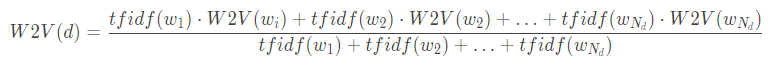

Βλέπουμε ότι τα tfidfs λειτουργούν ως βάρη. Στην συνέχεια υλοποιούμε τη συνάρτηση build_tfw2v η οποία δημιουργεί το corpus στο οποίο, σε κάθε ταινία αντιστοιχίζεται ένα διάνυσμα 300 διαστάσεων που έχει προκύψει από την παραπάνω σχέση.

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
  vectorizer = TfidfVectorizer(min_df = 0.005, max_df = 0.6)                #Χρησιμοποιούμε τις παραμέτρους για τις οποίες βρήκαμε καλά αποτελέσματα στο παραπάνω μέρος
  vectorizer.fit(corpus)
  corpus_tf_idf_plain = vectorizer.transform(corpus)
  corpus_tf_idf_plain = sparse.csr_matrix.toarray(corpus_tf_idf_plain)
  ans = []
  splitter = vectorizer.build_tokenizer()
  for i, summary in enumerate(corpus):
    words = splitter(summary)
    #print(i)
    #print(words)
    #print(len(words))
    counter = 0
    sum_nominator = 0
    tf_sum = 0
    for word in words:
      try:  
        tfidf = corpus_tf_idf_plain[i][vectorizer.vocabulary_[word]]
        #print(tfidf)
        sum_nominator += tfidf * vectors[word]
        tf_sum += tfidf
      except:
        #counter += 1
        #print(counter)
        continue
    try:    
      w2vd = sum_nominator / tf_sum    
      ans.append(w2vd)
    except:
      ans.append(np.zeros(embeddings_size))  
      continue
  ans = np.array(ans)
  return(ans)





Χρησιμοποιούμε το corpus στο οποίο έχουν φιλτραριστεί όσες λέξεις δεν ανήκουν στο προεκπαιδευμένο μοντέλο.

In [ ]:
new_corpus = build_tfw2v(np.reshape(corpus_df.iloc[:, [-1]].values, 5000).tolist(), model, 300)


In [ ]:
def content_recommender(target_movie, max_recommendations, corpus_type):
  similarities = []
  for movie in corpus_type:
    sim = cosine_similarity2(corpus_type[target_movie], movie)
    similarities.append(sim)
  similarities_tuple = enumerate(similarities)
  sorted_pairs = sorted(similarities_tuple, key = operator.itemgetter(1), reverse = True)  
  sorted_indices = []
  for index, _ in sorted_pairs:
    sorted_indices.append(index)

  print("Target movie's id: {}\nTitle {}\nSummary: {}\nCategories {}".format(target_movie, titles[target_movie], textwrap.fill(summaries[target_movie][0], 140), categories[target_movie]))
  sorted_indices.remove(target_movie)
  print("\n")
  print("Best Recommendations")
  print("\n")
  for i in range(max_recommendations):
    print("\t{}th most similar movie:\n\t\tid: {}\n\t\tCosine Similarity {} \n\t\tTitle: {}\n\t\tCategories: {}\n\t\tSummary: {}".format(i+1, sorted_indices[i], similarities[sorted_indices[i]], titles[sorted_indices[i]], categories[sorted_indices[i]], textwrap.fill(summaries[sorted_indices[i]][0], 140)))


Cherry picking:

In [ ]:
content_recommender(191, 5, new_corpus)

Target movie's id: 191
Title ['Crossing']
Summary: A romantic thriller, Crossing follows the story of macho Danarama , who makes a deathbed promise to his father to turn their family from
petty gangsters to upright brokerage owners. The only thing standing in Daniel's way is his newly discovered desire to dress up like a girl.
Embroiling himself in an intense romance with a blackmailing prostitute , Daniel must find a way through a maze of disgrace and pleasure to
discover where his real loyalties lie.
Categories ['"Crime Fiction",  "Romance Film",  "Drama",  "Indie"']


Best Recommendations


	1th most similar movie:
		id: 2289
		Cosine Similarity 0.8373526573286482 
		Title: ['10:30 P.M. Summer']
		Categories: ['"Romantic drama",  "Romance Film",  "Melodrama",  "Drama",  "Film adaptation"']
		Summary: Maria and Paul, a couple in their forties, travel through Spain with a new friend, Claire , a younger woman. The couple's daughter is also
part of the trip. On their way to Madrid, they

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Σε αυτή την περίπτωση το target movie είναι ένα ρομαντικό δράμα με πολλές εξελίξεις στην πλοκή. Ο recommender προτείνει ρομαντικά δράματα που έχουν παρόμοιο περιεχόμενο και μεγάλη πλοκή και για αυτό έχουν μεγάλο cosine similarity με την target movie.

In [ ]:
content_recommender(2021, 5, new_corpus)

Target movie's id: 2021
Title ['Goodbye Gemini']
Summary:  Jacki  and Julian  Dewar, a pair of fraternal twins, arrive via bus to London; they are home from university on Spring break, and their
father is in Mexico on business. The twins quickly set about mindlessly indulging themselves in the pleasures afforded to them by their
father's estate, much to the chagrin of their put-upon housekeeper, Mrs. McLaren. When Mrs. McLaren threatens to upset their carefree life
by imposing order upon it, they trip her down the stairs and stage it as an accident. Jacki and Julian launch themselves into London's
underground party scene, clubbing at strip bars, accompanied by Jacki's teddy bear, Agamemnon, whom the twins address as a father figure. At
one such club the pair encounter Clive, a small-time pimp who makes his way in the world by ingratiating himself with the wealthy and well-
connected. Clive quickly endears himself to Jacki, while Clive's sometimes girlfriend Denise attempts to befriend 

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Εδώ η target movie είναι μια crime movie με πολλές εξελίξεις στην πλοκή, φόνους και ερωτικές σκηνές. Ο recommender προτείνει ταινίες με παρόμοια πλοκή που έχουν αρκετά από τα στοιχεία της target movie.

Παρακάτω συγκρίνουμε τις προτάσεις του recommender Word2Vec με κάποιες προτάσεις του tfidf.

In [ ]:
content_recommender(112, 5, new_corpus)

Target movie's id: 112
Title ['A Killing Affair']
Summary: During World War II, an outsider, Baston Morris , comes to a tiny town looking for work at the local mill. He meets up with the town's evil
employer, Pink Gresham,  who abuses the men and has affairs with the women. Pink toys with Baston's plight but keeps the upper hand with his
pistol and chases Baston away. Baston then meets Pink's wife, Maggie , and spins a tale of her husbands philandering and Pink's personal
involvement with Baston's affairs at his hometown in the next county. The subplot contains stories of Maggie's brother, Shep Sheppard,  who
is a fundamentalist preacher that has followed his father's misogynistic ways. Sheppard sides with Pink when it comes to laying down the
law, and a hunt ensues for Baston after stories are revealed of him being an axe murderer. Screenplay was written and director by David
Saperstein
Categories ['"Crime Fiction",  "Thriller",  "Horror",  "Psychological thriller",  "Drama",  "Suspen

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Παραπάνω παρατηρούμε ότι οι συστάσεις είναι πολύ καλύτερες. Σε αυτή την περίπτωση ο tfidf έδινε μεγάλο βάρος στη λέξη pink πρότεινε ταινίες με τη λέξη pink μέσα, οι οποίες είχαν ωστόσο πολύ διαφορετική θεματολογία από την target movie. Αντιθέτως, ο word2vec recommender προτείνει δραματικές και ρομαντικές ταινίες, δηλαδή ίδια θεματολογία με την target movie και παρόμοια πλοκή.


In [ ]:
content_recommender(500, 5, new_corpus)

Target movie's id: 500
Title ['Pink in the Drink']
Summary: The Pink Panther embarks on a cruise to the South Seas for 14 days, but the luxurious holiday turns out to be a pirate ship operated by a
merciless pirate who orders the panther to mop the deck. The panther accidentally sets fire to the mast, and later loads cannonballs
incorrectly, causing the ship's weight to shift. Finally, when the pirate tries to kill a vicious shark with a cannon, the cannonball
instead cracks a hole in the ship and it sinks.
Categories ['"Short Film",  "Comedy film",  "Animation"']


Best Recommendations


	1th most similar movie:
		id: 1724
		Cosine Similarity 0.7508031889795085 
		Title: ['Raggedy Ann & Andy: A Musical Adventure']
		Categories: ['"Musical",  "Children\'s",  "Animation"']
		Summary: In October 1974, Raggedy Ann is the beloved doll of Marcella, along with her brother Raggedy Andy and a whole nursery full of colorful toys.
Whenever Marcella leaves the room, the dolls come to life. On Mar

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Είναι ενδιαφέρον ότι σε αυτή την περίπτωση, σε αντίθεση με τον απλό tfidf ο recommender καταλαβαίνει ότι η taget movie του ροζ πάνθηρα είναι μια παιδική ταινία και προτείνει τουλάχιστον στην αρχή και άλλες παιδικές ταινίες. Ωστόσο μετά την δεύτερη πρόταση πάλι προτείνει ταινίες για ενηλικες

In [ ]:
content_recommender(1497, 5, new_corpus)

Target movie's id: 1497
Title ['The Getting of Wisdom']
Summary: Laura Rambotham is sent to attend boarding school in Melbourne at the turn of the century. During her second year she tells everyone about a
made up romance between herself and the school's minister, Reverend Shepherd. She forms an attachment with an older girl, Evelyn. When
Evelyn leaves, Laura throws herself into her studies and wins the school literary and music prizes.
Categories ['"Drama"']


Best Recommendations


	1th most similar movie:
		id: 1869
		Cosine Similarity 0.8713412942536973 
		Title: ['The Sandpiper']
		Categories: ['"Romance Film",  "Melodrama",  "Drama"']
		Summary: Laura Reynolds  is a free-spirited, unwed single mother living with her young son Danny  in an isolated California beach house. She makes a
modest living as an artist and home-schools her son out of concern that he will be compelled to follow detrimental conventional social norms
in a regular school. Danny has gotten into some trouble wit

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Παραπάνω βλέπουμε πάλι ότι οι πρώτες τρεις προτάσεις είναι αρκετά καλές αλλά οι επόμενες όχι τόσο.

Γενικά ο word2vec recommender λαμβάνει υπόψη του τη σημασιολογία, το cosine similarity και τη συσχέτιση των λέξεων μεταξύ τους και έτσι είναι πιο ικανό να εντοπίσει κείμενα που έχουν παρόμοια ερμηνεία και περιεχόμενο. Για αυτό είναι σε θέση να κάνει πιο ακριβείς προβλέψεις για τις ταινίες που έχουν παρόμοια πλοκή και θεματολογία με την target movie. Επίσης μειώνει σημαντικά το μέγεθος των διαστάσεν των αναπαραστάσεων σε σχέση με τον απλό tfidf recommender και επομένως είναι υπολογιστικά πιο ελαφρύς

# Εφαρμογή 2: Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM

Μέσα από δοκιμές είδαμε ότι τα καλύτερα αποτελέσματα στο SOM, τα είχαμε για ένα corpus με περίπου 3.5 χιλιάδες features, το οποίο παράγω στο επόμενο cell. Θα χρησιμοποιήσω την ίδια διαδικασία κατασκευής του corpus_tf_idf_plain από το πρώτο μέρος, και θα του θέσω λίγο πιο αυστηρές τιμές για τα min_df και max_df, ώστε να φτιάξω το reduced_corpus_tf_idf_plain, το οποίο έχει το επιθυμητό πλήθος features.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.006, max_df=0.6)
vectorizer.fit(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
reduced_corpus_tf_idf_plain = vectorizer.transform(np.reshape(corpus_df.iloc[:, [-2]].values, 5000).tolist())
reduced_corpus_tf_idf_plain.shape

(5000, 3540)

Για το training, αυξάναμε συνεχώς το doc_limit και το μέγεθος του χάρτη SOM. Ξεκινήσαμε από 10x10 (στον οποίο δεν φαινόντουσαν καθόλου μπλε περιοχές και το KMeans δεν έκανε πολύ καλό clustering), σε 20x20 και τέλος σε 25x25.
To 20x20 και 25x25, είχαν περίπου τα ίδια αποτελέσματα. Βλέπουμε ότι για 90 εποχές σε 25x25 grid, και doc_limit=5000 πήρε 30 λεπτά το training.

In [ ]:
final_set = build_final_set(reduced_corpus_tf_idf_plain, doc_limit=5000)
som = somoclu.Somoclu(25, 25, compactsupport=True)
%time som.train(final_set, epochs=90)

CPU times: user 58min 15s, sys: 14.6 s, total: 58min 29s
Wall time: 30min 12s


In [ ]:
bmus = som.bmus   # BMU για κάθε ταινία
bmus.shape

(5000, 2)

In [ ]:
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
# το return_inverse επιστρέφει και τους δείκτες indices
# ubmus είναι τα μοναδικά BMUs  (μπορεί να είναι λίγο λιγότερα από 100)
# indices είναι το index του BMU που κέρδισε το κάθε δείγμα εισόδου
ubmus.shape

(543, 2)

Εφόσον το ubmus έχει μέγεθος (543, 2), καταλαβαίνουμε ότι υπήρχαν (25x25)-543=82 νευρώνες που δεν κέρδισαν καμία ταινία.

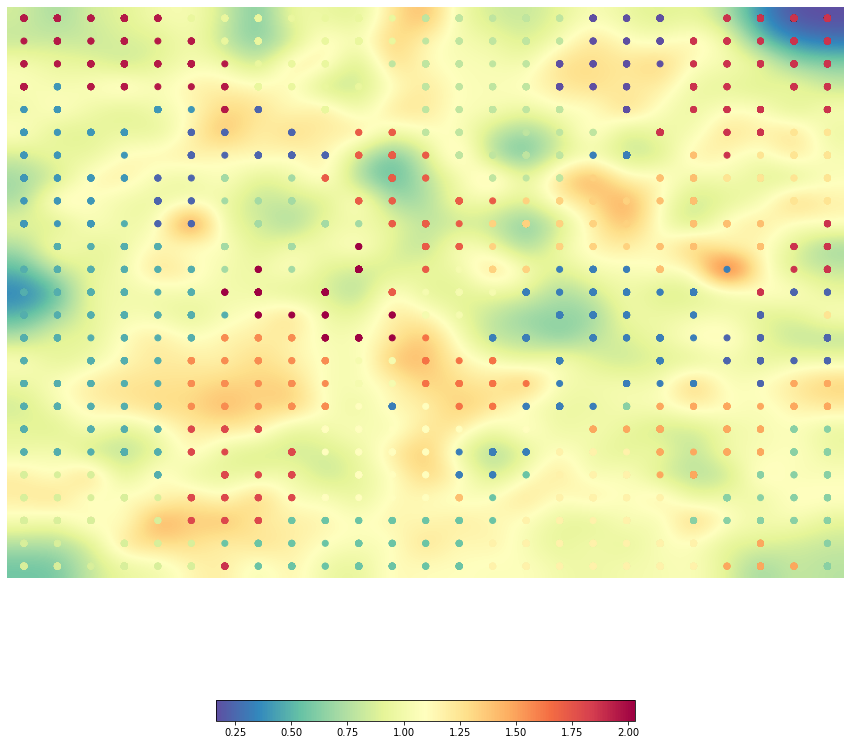

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
from sklearn.cluster import KMeans

som.cluster(algorithm=KMeans(25))
som.view_umatrix(bestmatches=True, figsize=(15,15), colorbar=True)

Από το παραπάνω Umatrix, μπορούμε να διακρίνουμε κάποια εμφανή clusters, τα οποία είναι οι μπλε-πράσινες περιοχές (χωρισμένες από τις κοκκινωπές περιοχές ορίων). Όσον αφορά το clustering, τα καλύτερα αποτελέσματα τα πήραμε με k=25, το οποίο έπιανε και μερικές μικρές υποκατηργορίες, που δεν εμφανιζόντουσαν πάντα για k=20.

Επίσης, πρέπει να σημειωθεί ότι μία μεγάλη πλειοψηφία των ταινιών που αντιστοιχούν στον αριθμό της ομάδας μου, έχουν το genre "Drama" (σχεδόν οι μισές). Αυτό οδηγούσε πάντα στην δημιουργία ενός πολύ πυκνού cluster, για οποιαδήποτε αρχικοποίηση του SOM ή KMeans χρησιμοποιούσαμε. Αυτό το cluster μπορεί να φανεί στον παραπάνω Umatrix, στην πάνω δεξιά γωνία. Παρόμοια σκούρα-μπλε περιοχή υπήρχε σε όλα τα Umatrix που φτιάξαμε, και αντιστοιχεί σε πολλές ταινίες που έχουν genre "Drama".

In [ ]:
import joblib
joblib.dump(reduced_corpus_tf_idf_plain, "reduced_corpus_for_som.pkl")
joblib.dump(som.clusters, "som_clusters.pkl")
joblib.dump(som.bmus, "som_bmus.pkl")

['som_bmus.pkl']

Παρακάτω βλέπουμε τα clusters που έδωσε το Kmeans

In [ ]:
som.clusters

[[23 23 23 23 23 10 10 10 10 10 10 10  8  8  8  8  8  0  0  0  0 22 22 22 22]
 [23 23 23 23 23 23 10 10 10 10 10 10  8  8  8  8  8  0  0  0 22 22 22 22 22]
 [23 23 23 23 23 23 23 10 10 10 10  8  8  8  8  8  0  0  0  0 22 22 22 22 22]
 [23  3 23 23 23 23 23 10 10 10 10 10  8  8  8  8  0  0  0 22 22 22 22 22 22]
 [ 3  3  3  3  3  3 23  1 10 10 10 20  8  8  8  8  8  0  0 22 22 22 22 22 22]
 [ 3  3  3  3  3  1  1  1  1  2 20 20  8  8  8  8  8  8  2 22 22 22 22 14 14]
 [ 3  3  3  3  1  1  1  1  1  1 20 20 20  8  8  8  8  2  2  2 16 22 14 14 14]
 [ 3  3  3  3  1  1  7  7  7 20 20 20 20 20  8  8  8 15  2 16 16 14 14 14 14]
 [ 3  3  3  1  1  1  7  7  7  7 20 20 20 20 20 15 15 15 15 16 16 16 14 14 14]
 [ 3  3  3  4  1  1  7  7  7  7  7 20 20 20 15 15 15 15 15 16 16 16 16 22 22]
 [ 3  4  4  4  4  7  7  7  7  7 24 20 20 20 15 15 15 15 15 16 16 16 16 22 22]
 [ 4  4  4  4  4  4  7 24  7 24 24 24 20 11 15 15  2  2  2 16  2  2 16 22 22]
 [ 4  4  4  4  4  4 24 24 24 24 24 20 11 11 11  2  2  2  2  2  2

Βλέπουμε ότι τους περισσότερους νευρώνες τους κέρδισε το Cluster 4 (57 νευρώνες), και τους λιγότερους το Cluster 19 (10 νευρώνες)

In [ ]:
counts = np.bincount(som.clusters.flatten())
for i in np.argsort(counts)[::-1]:
  print(f"Cluster {i} has won {counts[i]} neurons")

Cluster 4 has won 57 neurons
Cluster 2 has won 56 neurons
Cluster 22 has won 39 neurons
Cluster 8 has won 37 neurons
Cluster 1 has won 32 neurons
Cluster 13 has won 30 neurons
Cluster 17 has won 27 neurons
Cluster 3 has won 27 neurons
Cluster 23 has won 25 neurons
Cluster 10 has won 25 neurons
Cluster 9 has won 25 neurons
Cluster 20 has won 24 neurons
Cluster 5 has won 24 neurons
Cluster 6 has won 20 neurons
Cluster 12 has won 20 neurons
Cluster 7 has won 19 neurons
Cluster 21 has won 19 neurons
Cluster 24 has won 18 neurons
Cluster 18 has won 18 neurons
Cluster 15 has won 17 neurons
Cluster 16 has won 17 neurons
Cluster 0 has won 16 neurons
Cluster 14 has won 13 neurons
Cluster 11 has won 10 neurons
Cluster 19 has won 10 neurons


Η print_categories_stats παίρνει ως όρισμα μία λίστα από IDs ταινιών, και επιστρέφει σε φθίνουσα σειρά τις πιο συχνές κατηγορίες που βρίσκονται σε αυτήν την λίστα. Ως παράδειγμα, έχουμε βάλει να δούμε τις κατηγορίες από τις πρώτες 50 ταινίες του corpus που μάς αντιστοιχεί.

In [ ]:
def keep_words(categories):                                    # βοηθητική συνάρτηση, για επεξεργασία του string που παίρνουμε από το categories
  ans = []
  for i in categories:
    if any([x.isalpha() for x in i]):
      ans.append(i)
  return ans

def print_categories_stats(movies):
  total_categories = []
  for id in movies:
    add = keep_words(categories[id][0].split('"'))
    total_categories.extend(add)
  genres, counts = np.unique(np.array(total_categories), return_counts=True)
  ind = np.argsort(counts)[::-1]
  return list(zip(genres[ind], counts[ind]))

print_categories_stats(list(range(50)))

[('Drama', 19),
 ('Action', 12),
 ('Comedy', 12),
 ('Thriller', 11),
 ('Adventure', 7),
 ('Horror', 7),
 ('Mystery', 7),
 ('Black-and-white', 6),
 ('Crime Fiction', 5),
 ('Action/Adventure', 4),
 ('Comedy-drama', 4),
 ('Family Film', 4),
 ('Psychological thriller', 4),
 ('Romance Film', 3),
 ('Bollywood', 3),
 ('Parody', 3),
 ('World cinema', 3),
 ('Supernatural', 3),
 ('Short Film', 3),
 ('Television movie', 3),
 ('Romantic comedy', 2),
 ('Japanese Movies', 2),
 ('Crime Drama', 2),
 ('Cult', 2),
 ('Screwball comedy', 2),
 ('Creature Film', 2),
 ('Animation', 2),
 ('Satire', 2),
 ('Science Fiction', 2),
 ('Suspense', 1),
 ('Coming of age', 1),
 ('Action Thrillers', 1),
 ('Comedy of Errors', 1),
 ('Comedy film', 1),
 ('Tragicomedy', 1),
 ('Art film', 1),
 ('Sword and sorcery films', 1),
 ('Blaxploitation', 1),
 ('Addiction Drama', 1),
 ('Computer Animation', 1),
 ('Tragedy', 1),
 ('Biographical film', 1),
 ('Black comedy', 1),
 ('Crime Thriller', 1),
 ('Spaghetti Western', 1),
 ('Horror

Η neuron_movies_report παίρνει ως όρισμα μία λίστα νευρώνων, και επιστρέφει τα IDs από τις ταινίες που αντιστοιχούν σε αυτούς τους νευρώνες (ψάχνει πρώτα στον πίνακα των bmus για να βρει εκεί τους ζητούμενους νευρώνες).

In [ ]:
def neuron_movies_report(neurons):
  total_movies = set()
  for neuron in neurons:
    movie_ids = np.nonzero(np.apply_along_axis((lambda x:np.array_equal(x,neuron)), axis=1, arr=bmus))[0]
    for id in movie_ids:
      total_movies.add(id)
  return list(total_movies)

Τέλος, η print_cluster_neurons_movies_report παίρνει σαν είσοδο τον αριθμό ενός cluster, και επιστρέφει τις κυρίαρχες κατηγορίες αυτού του cluster. Αυτό το πετυχαίνει χρησιμοποιώντας τις δύο συναρτήσεις που ορίσαμε προηγουμένως (πρώτα καλέι την neuron_movies_report, και μετά την print_categories_stats πάνω στις ταινίες που βρήκε).

In [ ]:
def print_cluster_neurons_movies_report(cluster):
  h, b = np.nonzero(som.clusters==cluster)
  neurons = np.stack((b, h), axis=1)                # βάζω πρωτα το b και μετα το h, επειδη η Somoclu τα αποθηκευει ως στηλη-σειρα
  total_movies = neuron_movies_report(neurons)
  return print_categories_stats(total_movies)

Παράδειγμα, οι κυρίαρχες κατηγορίες του cluster 4 (είναι προφανές ότι περιέχει κωμωδίες).

In [ ]:
print_cluster_neurons_movies_report(4)

[('Comedy', 535),
 ('Drama', 148),
 ('Indie', 70),
 ('Parody', 57),
 ('Family Film', 51),
 ('Comedy-drama', 51),
 ('Musical', 44),
 ('Black comedy', 41),
 ('Satire', 34),
 ('Slapstick', 33),
 ('Crime Fiction', 28),
 ('Sports', 28),
 ('World cinema', 22),
 ('Fantasy', 22),
 ('Teen', 21),
 ('Romantic comedy', 20),
 ('Adventure', 17),
 ('Science Fiction', 17),
 ('Black-and-white', 17),
 ('Buddy film', 16),
 ('Film adaptation', 15),
 ('Family Drama', 14),
 ('Sex comedy', 14),
 ('Coming of age', 14),
 ('Period piece', 13),
 ('Domestic Comedy', 12),
 ('Ensemble Film', 12),
 ('Cult', 12),
 ('Horror', 12),
 ('Action', 11),
 ('Musical comedy', 11),
 ('Romance Film', 10),
 ('Road movie', 10),
 ('Screwball comedy', 10),
 ('Crime Comedy', 10),
 ('Media Satire', 9),
 ('Mystery', 9),
 ('Television movie', 9),
 ('Gross out', 8),
 ('Gross-out film', 8),
 ('Chinese Movies', 8),
 ('Thriller', 8),
 ('Comedy of Errors', 8),
 ('Political cinema', 7),
 ('Bollywood', 7),
 ('Fantasy Comedy', 7),
 ('Comedy fil

In [ ]:
for i in range(25):
  print(f"Cluster {i} has these majors: {print_cluster_neurons_movies_report(i)[0]} {print_cluster_neurons_movies_report(i)[1]} {print_cluster_neurons_movies_report(i)[2]}")

Cluster 0 has these majors: ('Horror', 115) ('Science Fiction', 74) ('Creature Film', 44)
Cluster 1 has these majors: ('Black-and-white', 182) ('Drama', 87) ('Comedy', 74)
Cluster 2 has these majors: ('Action', 75) ('Comedy film', 70) ('Silent film', 57)
Cluster 3 has these majors: ('Comedy', 216) ('Romance Film', 215) ('Romantic comedy', 156)
Cluster 4 has these majors: ('Comedy', 535) ('Drama', 148) ('Indie', 70)
Cluster 5 has these majors: ('Action', 146) ('Action/Adventure', 126) ('Comedy', 79)
Cluster 6 has these majors: ('Thriller', 161) ('Mystery', 132) ('Crime Thriller', 102)
Cluster 7 has these majors: ('Short Film', 84) ('Comedy', 84) ('Black-and-white', 51)
Cluster 8 has these majors: ('Horror', 277) ('Thriller', 89) ('Slasher', 72)
Cluster 9 has these majors: ('World cinema', 235) ('Drama', 214) ('Bollywood', 43)
Cluster 10 has these majors: ('Romance Film', 229) ('Drama', 151) ('Comedy film', 40)
Cluster 11 has these majors: ('Animation', 37) ('Fantasy', 11) ("Children's/F

In [ ]:
print_categories_stats(list(range(5000)))

[('Drama', 2292),
 ('Comedy', 1232),
 ('Romance Film', 783),
 ('Thriller', 770),
 ('Action', 704),
 ('World cinema', 611),
 ('Horror', 525),
 ('Crime Fiction', 477),
 ('Action/Adventure', 436),
 ('Black-and-white', 423),
 ('Indie', 402),
 ('Adventure', 401),
 ('Short Film', 398),
 ('Family Film', 396),
 ('Romantic drama', 295),
 ('Animation', 282),
 ('Musical', 272),
 ('Science Fiction', 269),
 ('Mystery', 265),
 ('Fantasy', 255),
 ('Comedy film', 234),
 ('Romantic comedy', 226),
 ('War film', 192),
 ('Crime Thriller', 176),
 ('Silent film', 159),
 ('Period piece', 155),
 ('Documentary', 151),
 ('Comedy-drama', 148),
 ('Psychological thriller', 146),
 ('Film adaptation', 143),
 ('Western', 142),
 ('Japanese Movies', 138),
 ('Bollywood', 119),
 ('Chinese Movies', 109),
 ('Teen', 107),
 ('Family Drama', 100),
 ('Television movie', 99),
 ("Children's/Family", 99),
 ('Sports', 98),
 ('Black comedy', 95),
 ('Coming of age', 92),
 ('Parody', 91),
 ('Suspense', 87),
 ('Slasher', 86),
 ('Super

### ΤΟΠΟΛΟΓΙΚΕΣ ΙΔΙΟΤΗΤΕΣ SOM:

1)Από το παραπάνω κελί, μπορούμε να δούμε ότι τα δεδομένα που έχουν την μεγαλύτερη πιθανότητα να εμφανιστούν είναι τα Drama και τα Comedies. Αν ξανακοιτάξουμε το κελί όπου υπολογίζουμε τα clusters με τους περισσότερους νευρώνες, θα δούμε ότι το πρώτο είναι το Cluster 4, μετά το Cluster 2, μετά το 22, μετά το 8, και μετά ακολουθούν τα υπόλοιπα. Το Cluster 4, όπως βλέπουμε και παραπάνω, έχει κυρίαρχη κατηγορία το Comedy, η οποία είναι μία από τις πιο συχνές κατηγορίες του corpus μας.Στο Cluster 2, έχουμε κυρίαρχες κατηγορίες τα Action και Comedy, οι οποίες είναι και οι δύο πολύ συχνές κατηγορίες. Ομοίως στο Cluster 22, κυριαρχεί η κατηγορία Drama, η οποία είναι η πιο συχνή κατηγορία του corpus. Στο Cluster 8 κυριαρχεί η κατηγορία Horror, η οποία είναι στις 525, από τις 5000 ταινίες του corpus μας. Άρα μπορούμε να δούμε ότι επιβεβαιώνετε η ιδιότητα, ότι τα δεδομένα που έχουν περισσότερη πιθανότητα εμφάνισης στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες.

2)Για την εξής ιδιότητα των SOM, μπορούμε να συγκρίνουμε τα Cluster 4 και 6. Το Cluster 4, όπως είδαμε προηγουμένως, έχει κυρίαρχη κατηγορία το Comedy, ενώ το Cluster 6 έχει κυρίαρχη κατηγορία τα Thriller/Mysteries. Μπορούμε να καταλάβουμε ότι τα πρότυπα εισόδου θα είναι μακριά, λόγω του πολύ διαφορετικού σημασιολογικού περιεχομένου. Αν κοιτάξουμε και τον πίνακα με τα Clusters, θα δούμε ότι το Cluster 4 βρίσκεται μέση-αριστερά, ενώ το 6 βρίσκεται στην κάτω-δεξιά γωνία. Ομοιώς αν συγκρίνουμε το Cluster 10 με το 6. Το 10 έχει κυρίαρχη κατηγορία το Romance, άρα είναι λογικό να απεικονίζεται μακριά από το 6 (Horror). Αυτό επιβεβαιώνετε αφού το Cluster 10 βρίσκεται πάνω-αριστερά στο SOM, και το Cluster 6 βρίσκεται στην κάτω δεξιά γωνία.

3)Για το αντίστροφο της παραπάνω ιδιότητας, αν πάρουμε δύο Clusters, που έχουν κοντινές κυρίαρχες κατηγορίες, θα δούμε ότι βρίσκονται κοντά στον χάρτη. Μπορούμε να κοιτάξουμε τα Clusters 3, 4 και 7, τα οποία είναι όλα δίπλα το ένα στο άλλο, στον χάρτη των clusters. To 3 έχει κυρίαρχα Comedy/Romance, το 4 Comedy/Drama, και το 7 Comedy/Short-Film. Άλλα είναι λογικό ότι μοιράζονται το χαρακτηριστικό του Comedy, γι'αυτό εμφανίζονται τόσο κοντά. Ομοίως, μπορούμε να δούμε τα Clusters 18 και 24, που έχουν ως κυρίαρχες κατηγορίες Family/Children και Family/Animation αντίστοιχα. Βρίσκονται και οι δύο δίπλα-δίπλα στον χάρτη (σχεδόν στο κέντρο του χάρτη), λογικό, αφού και τα δύο clusters μοιράζονται το χαρακτηριστικό των Family Movies, άρα θα έιναι κοντινά στην είσοδο.

### Ενδιαφέρον Clusters

Ένα "περίεργο" cluster είναι το Cluster 2. Βλέπουμε ότι οι κυρίαρχες κατηγορίες του είναι Action και Comedy, και ότι είναι ένα από τα clusters που έχουν τους περισσότερους νευρώνες.

Το ενδιαφέρον στοιχείο, είναι ότι, αφού έχει κερδίσει τόσο πολλούς νευρώνες, θα περιμέναμε οι κυρίαρχες κατηγορίες να έχουν πολλές ταινίες (πχ στο Cluster 4 έχουμε 535 Comedies, στο Cluster 22 έχουμε 715 Dramas κοκ...), άλλα έχει μόνο 75 Action και 70 Comedy Films.

Το άλλο περίεργο χαρακτηριστικό του είναι ότι αν δούμε τα γειτονικά του Clusters, αυτά είναι τα 19, 11, 15, 16, 1 και 17. Αυτά έχουν τις εξής κυρίαρχες κατηγορίες:
- 19: Japanese/Anime
- 11: Animation
- 15: Documentary
- 16: Crime Fiction
- 1: Black-and-White
- 17: Thriller

Μπορούμε να δούμε, ότι κανένα από αυτά δεν έχει σχέση με τα Action/Comedies του Cluster 2.

Αυτά τα δύο περίεργα χαρακτηριστικά τού Cluster 2, μπορούν να ερμηνευτουν και διαισθητικά, αλλά και μέσω του χάρτη. Αρχικά, διαισθητικά, μπορούμε να καταλάβουμε ότι δεν υπάρχουν πολλές Κωμωδίες οι οποίες να είναι και ταινίες Δράσης. Επίσης μπορούμε να καταλάβουμε ότι αυτό επηρέασε την διαδικασία Clustering και προσδιορισμό των bmus αν κοιτάξουμε τον χάρτη. Στην περιοχή όπου βρίσκεται το Cluster 2(κέντρο-δεξιά), μπορούμε να δούμε ότι έχει αρκετούς νευρώνες, οι οποίοι δεν κέρδισαν καμία ταινία. Αυτό σημαίνει ότι το Cluster, πήρε πολλούς νευρώνες, οι οποίοι δεν έιναι κοντινοί μεταξύ τους.

Αυτό μπορούμε να το επεβεβαιώσουμε αν κοιτάξουμε λίγο περισσότερες κυρίαρχες κατηγορίες του Cluster:

In [ ]:
print_cluster_neurons_movies_report(2)[:10]

[('Action', 75),
 ('Comedy film', 70),
 ('Silent film', 57),
 ('Western', 49),
 ('Japanese Movies', 34),
 ('Action/Adventure', 30),
 ('Science Fiction', 27),
 ('Musical', 27),
 ('Chinese Movies', 17),
 ('Family Film', 13)]

Βλέπουμε ότι έχει ταινίες από πάρα πολλές κατηγορίες. Άρα για αυτό φταίει το ότι έχει πολλούς νευρώνες οι οποίοι δεν κέρδισαν καμιά ταινία, άρα πήγε το Cluster και "ενσωμάτωσε" πολλούς μικρούς διπλανούς νευρώνες(πιθανώς με αρκετά outliers), εξού και η ιδιομορφία του Cluster.

Σε γενικές γραμμές, τα υπόλοιπα clusters έχουν αρκετά σαφή χαρακτηριστικά, και "λογικούς" γείτονες (κοιτώντας τα χαρακτησριστικά τους).

Γενικά ως προς το μέγεθος των Clusters, πάλι βλέπουμε ότι τα αποτελέσματα είναι λογικά: Μεγάλα clusters με Drama/Action/Comedy/Romance, μικρότερα με Documentary/Animation/Family.

Εδώ να κρατήσουμε την παρατήρηση που είχε γίνει νωρίτερα για το Cluster 22, το οποίο είναι ένα γιγάντιο Cluster, με 715 ταινίες Drama. Ένα τέτοιο cluster, δυστυχώς δεν μπορέσαμε να το αποφύγουμε με κάποια διαφορετική αρχικοποίηση του SOM/KMeans, και οφείλεται στο ότι έχουμε πάρα πολλές ταινίες στο corpus οι οποίες έχουν το category Drama.